### Comparision with Epi/H and Epi states
Note that this script reproduces our analyses shown in Figure 5.

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.linalg
import itertools
import networkx as nx
import copy
import os
from scipy.stats import ttest_ind

from modules.drawFig import removeN1

/home/nhkim/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


          X-axis  statistic       p-value
0  Ecadherin_act  -0.374671  7.088492e-01
1     miR200_act  -1.547677  1.254595e-01
2      miR34_act  -1.048450  2.974385e-01
3       ZEB1_act   1.292950  1.995731e-01
4      Snail_act   0.374671  7.088492e-01
5     Twist1_act   9.139385  3.109660e-14
6      EpCAM_act   6.136282  2.672791e-08
7        MYC_act   1.457929  1.485890e-01
8       THY1_act   1.533723  1.288557e-01


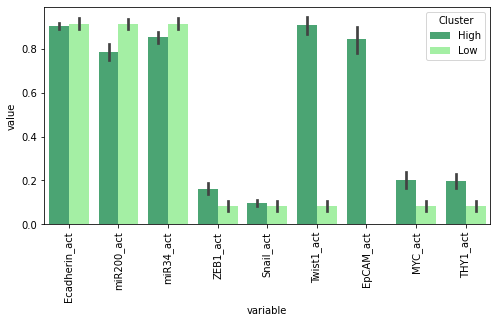

In [3]:
# triple node perturbation analysis (TGFOFF and TGFON)

# ============
# Figure 5
# ============

# Load simulation merged datasets
# Please refer to '7-Relative stability of the circuit.ipynb'
datadir = './result/TGFON/'
df_all = pd.read_csv(datadir+'TGFON_triple_merged.csv', index_col=0) 

# E Group
my_pal = {"Low": "#98FB98", "High":'#3CB371'}
       
df_all_E = df_all.loc[df_all["Diff_pheno_act"]==-1]
df_all_E = pd.concat([df_all_E, pd.DataFrame(['High' for _ in range(df_all_E.shape[0])], columns=['Cluster'], index=df_all_E.index)],axis=1)
df_all_E = pd.concat([df_all_E, pd.DataFrame((df_all_E.Twist1_act.values + df_all_E.EpCAM_act.values)/2, columns=['Ave2'], index=df_all_E.index)],axis=1)
lowc = (np.round(df_all_E.Ave2,5) < 0.5) & (np.round(df_all_E.Twist1_act,5) < 0.5) & (np.round(df_all_E.EpCAM_act,5) < 0.5)
df_all_E.loc[lowc,'Cluster'] = 'Low'

stacked = df_all_E.loc[:,set(df_all_E.columns)-set(['Pheno','PC1','PC2'])].melt(id_vars=['Cluster'])
stacked2 = stacked.groupby(['Cluster','variable']).agg(np.mean)

# ============
# Figure 5A
# ============
ttest_ind_result = []

plt.figure(figsize=(8,4))
selected_name = [x+'_act' for x in ['Ecadherin', 'miR200', 'miR34', 'ZEB1', 'Snail', 'Twist1', 'EpCAM','MYC', 'THY1']]
ax = sns.barplot(x="variable", y="value", hue="Cluster",hue_order = ['High','Low'], data=stacked.loc[[x in selected_name for x in stacked.variable],: ], order = selected_name, palette=my_pal)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

for stacked_v in selected_name:
    ttest_ind_result.append([stacked_v] + list(ttest_ind(*stacked.loc[stacked.variable == stacked_v,:].groupby('Cluster')['value'].apply(lambda x:list(x)))))
ttest_ind_result = pd.DataFrame(ttest_ind_result, columns = ['X-axis','statistic','p-value'])
print(ttest_ind_result)


<AxesSubplot:>

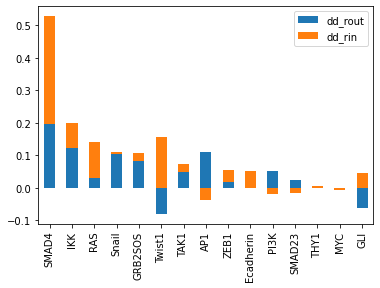

In [5]:
# ============
# Figure 5B
# ============
stackedH_mean = stacked.loc[stacked.Cluster == 'High',:].groupby(['variable']).agg(np.mean)
stackedL_mean = stacked.loc[stacked.Cluster == 'Low',:].groupby(['variable']).agg(np.mean)

delta = stackedH_mean-stackedL_mean

rin = delta.loc[['_in' in x for x in delta.index],:]
rout = delta.loc[['_out' in x for x in delta.index],:]
rin.index = [x.split('_')[0] for x in rin.index]
rout.index = [x.split('_')[0] for x in rout.index]

res = pd.concat([rin,rout],axis=1).iloc[:-1,:]
res = res.fillna(0)
res = pd.concat([res, np.sum(res,axis=1)],axis=1)
res.columns = ['dd_rin','dd_rout','sum']
res.sort_values(by='sum',ascending=False).loc[:,['dd_rout','dd_rin']].iloc[:15,:].plot.bar(stacked=True)


In [6]:
def draw_surface3D_customized(df, axis_name, surface_color): 
    # There is the same function in drawFig.py, but some values have been customized to reproduce the figure.
    data = np.array(df.loc[:,axis_name])
    
    min_ = np.min(data, axis=0)
    max_ = np.max(data, axis=0)
    X,Y = np.meshgrid(np.linspace(min_[0], max_[0], 20), np.linspace(min_[1], max_[1], 20))
    XX = X.flatten()
    YY = Y.flatten()
        
    # best-fit quadratic curve (2nd-order)
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
        
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)
        
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z-0.01, rstride=2, cstride=2, alpha=0.2, cmap=surface_color)

    palette = {'#9E0142':'#9E0142','#F39001':'#F39001','#5E4FA2':'#5E4FA2',"#98FB98": "#98FB98", "#3CB371":'#3CB371'}
    for color in set(df.Pheno):    
        dataset = df.loc[(df.Pheno==color).values,axis_name].values
        print(dataset.shape)
        ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], c=palette[color], alpha=0.5, s=150)
        ax.view_init(10, 10)

    plt.xlabel(axis_name[0])
    plt.ylabel(axis_name[1])
    ax.set_zlabel(axis_name[2])


/home/nhkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


(82, 3)
(6726, 3)
(1739, 3)
(4, 3)


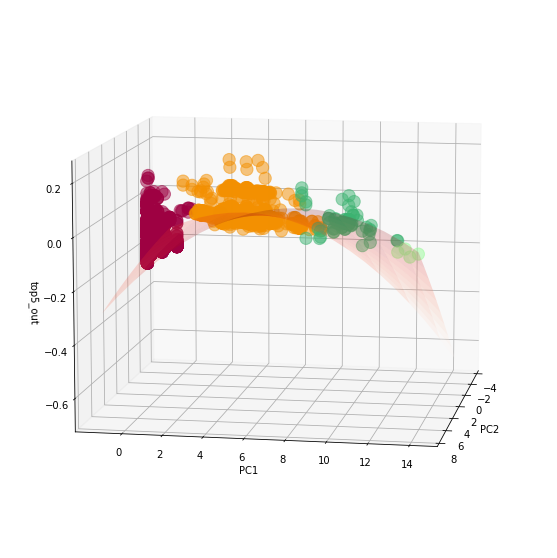

In [7]:
# ============
# Figure 5D
# ============
surface_color = 'Reds'

df_all2 = pd.merge(df_all, df_all_E.loc[:,['Cluster','Ave2']], how = 'outer', left_index=True, right_index=True)
cnames = set(['miR34', 'Snail']+['miR34', 'Snail', 'ZEB1'] + ['Snail', 'Twist1', 'AP1']+ ['SMAD4','ERK'] +['miR200','ZEB1']) #top5
df_all2.loc[:,'top5_out'] = np.mean(df_all2.loc[:, [x+'_out' for x in cnames]],axis=1).values #top5

color_dict = {'1':'#9E0142','0':'#F39001','-1':'#5E4FA2'}
my_pal = {"Low": "#98FB98", "High":'#3CB371'}
df_all2.loc[:,'Pheno'] = [color_dict[str(x)] if x != -1 else my_pal[y] for x,y in zip([int(x) for x in df_all2.Diff_pheno_act], df_all2.Cluster)]


draw_surface3D_customized(df_all2,['PC2','PC1','top5_out'],surface_color)